# Visualising convnet filters in VGG-16



## Importing libraries

In [1]:
!pip3 install tensorflow-gpu==1.15.2

In [2]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

## Loading model

In [3]:
model = VGG16(weights='imagenet', include_top=False)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________

## Utility function to make tensor displayable

In [4]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## Kernel visualiser

In [5]:
def generate_pattern(layer_name, filter_index, size=150):
    # Defining loss tensor
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Getting gradient
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # gradient normalising trick (Dividing gradient tensor by its l2 norm)

    # Fetching numpy o/p for numpy i/p
    iterate = K.function([model.input], [loss, grads])
    loss_value, grads_value = iterate([np.zeros((1, size, size, 3))])

    # Loss maximization via stochastic gradient descent (*Gradient Ascent*)
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128 #Gray image with some noise

    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data]) #Above 2 lines do gradient ascent
        input_img_data += grads_value * step #adjusts inp image towards the dir that maximizes the loss
    
    img = input_img_data[0]
    return deprocess_image(img)
    

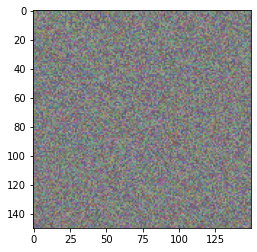

In [6]:
plt.imshow(generate_pattern('block2_conv1', 0))

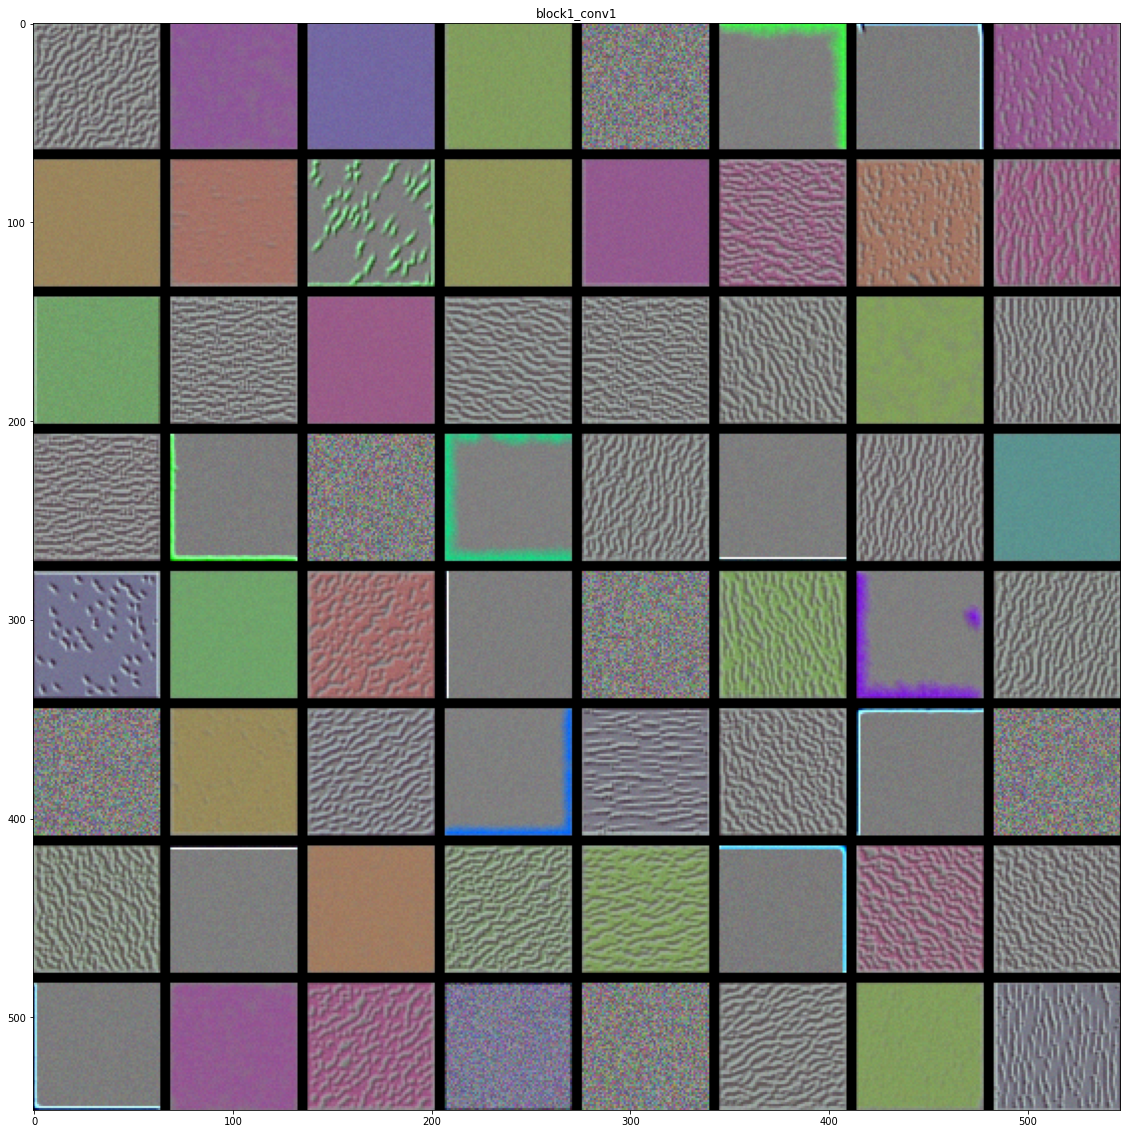

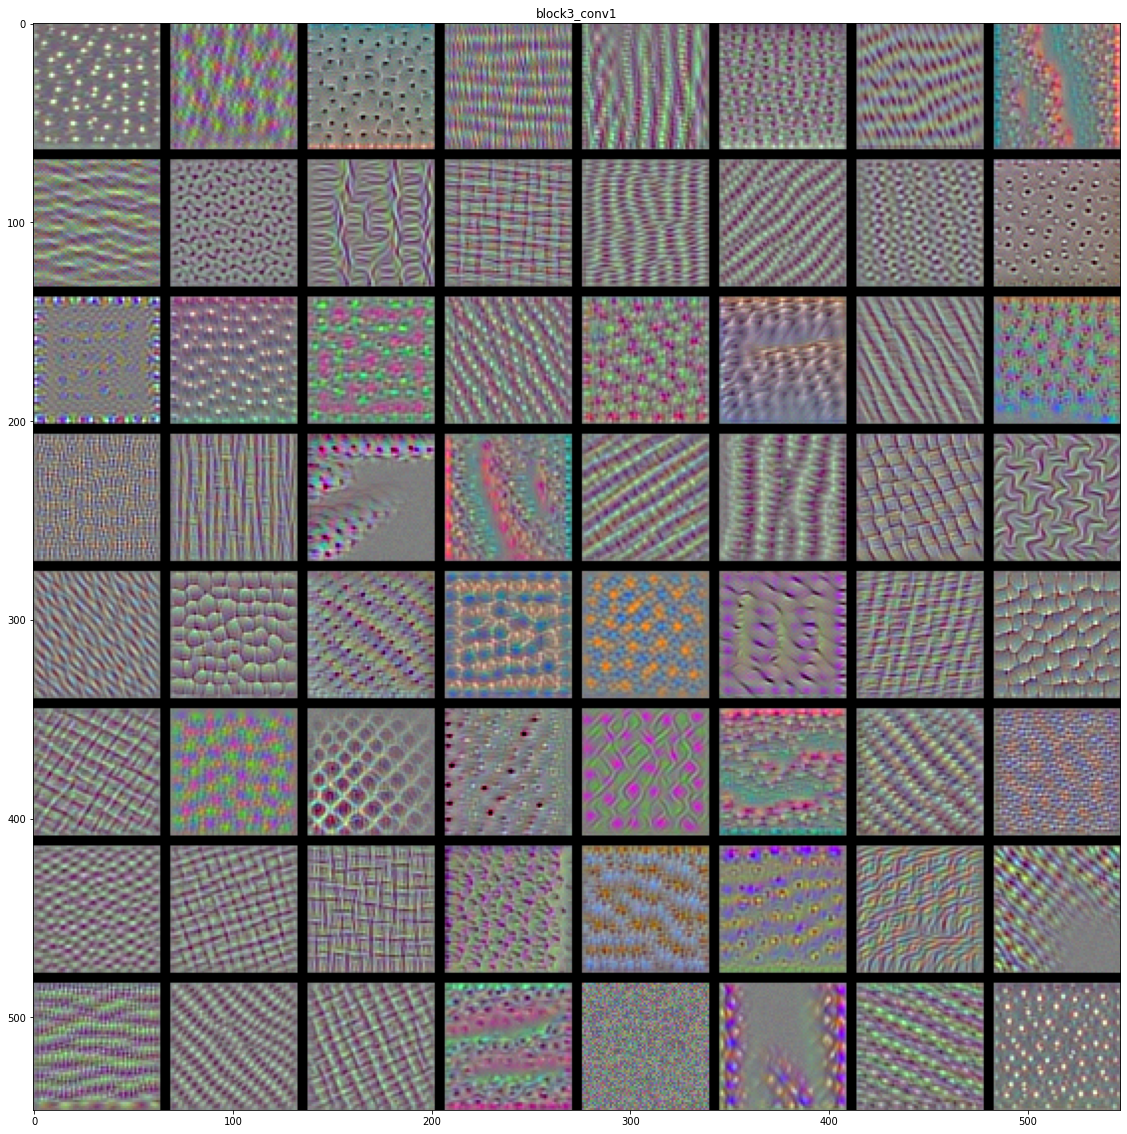

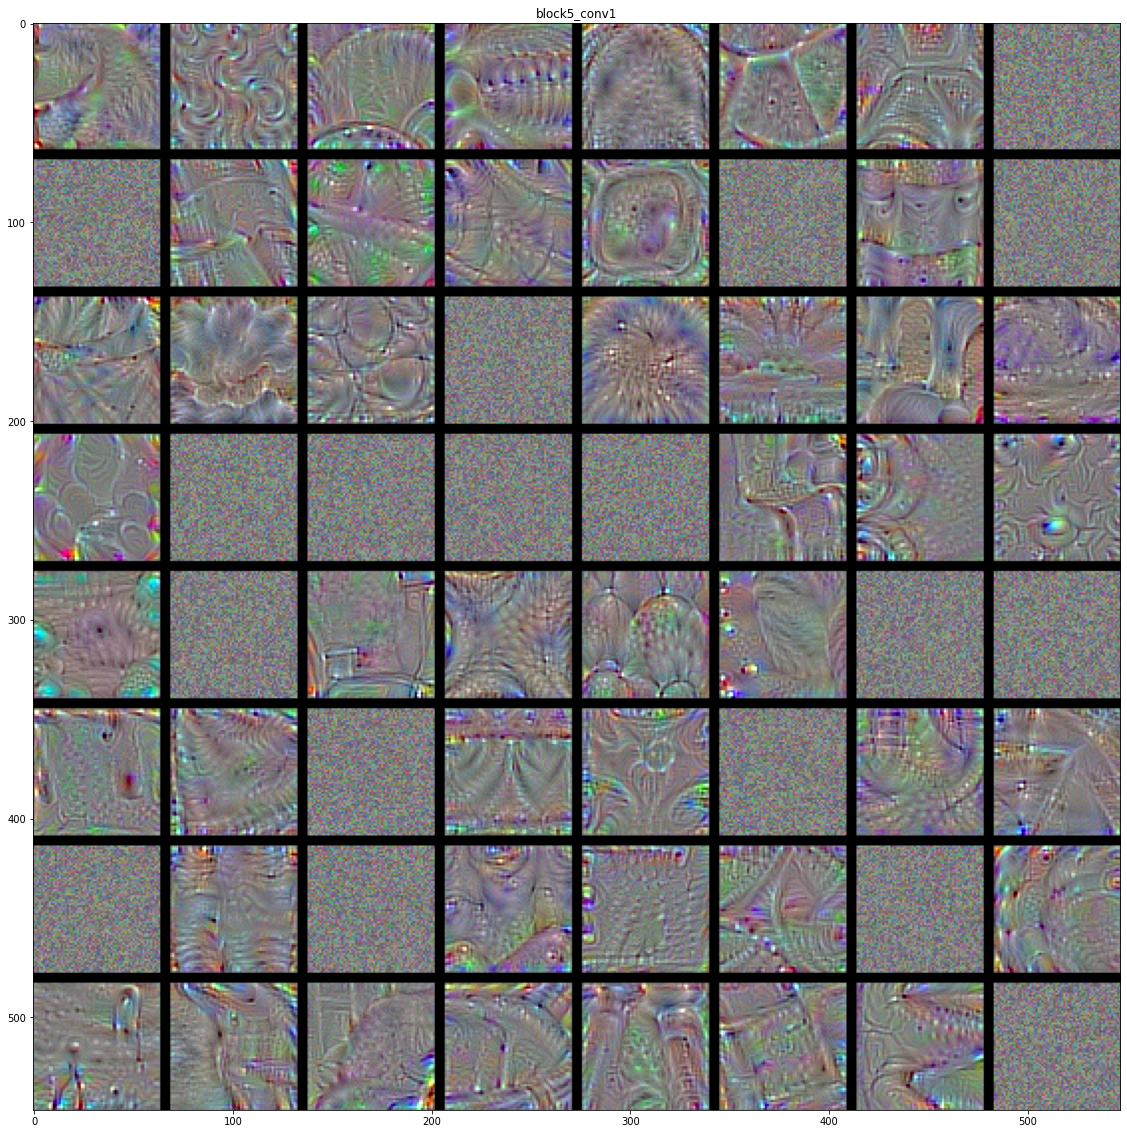

In [7]:
for layer_name in ['block1_conv1', 'block3_conv1', 'block5_conv1']:
    size = 64
    margin = 5
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype='uint8')

    for i in range(8):
        for j in range(8):
            filter_img = generate_pattern(layer_name, i+(j*8), size=size)

            horizontal_start = i*size+i*margin
            horizontal_end = horizontal_start + size
            vertical_start = j*size+j*margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.title(layer_name)
    plt.show()